In [1]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

- After importing the package to be used, I need to use `read_csv()` to read the dataset. The dataframe name is setted to `data_players`. Using a relevant path `data/players.csv`to insert the data.
- `head()` is designed to read first several rows of dataset.

In [2]:
data_players<-read_csv("data/players.csv")
head(data_players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Data Explanation
#### From the read dataset, we can see that there are 7 main variables. However, only three are suitable for the prediction.
- Experience: Describing a player's proficiency in a game is divided into five levels.
- Age: The player's age
- Time of playing: Time spent playing the game.

### I expect both player's age and played time are predictive of subscribing the game_related newsletter. We assume that the longer players spend playing games, the more willing they are to subscribe to game-related newsletters. Players who are too old are not very willing to subscribe to newsletters.

In [4]:
players_new_frame <- mutate(data_players,subscribe =as.factor(subscribe))|> select(played_hours, Age, subscribe)|> drop_na()
players_new_frame  |> summarize(max_hr = max(played_hours), mean_hr = mean(played_hours, na.rm=TRUE))
head(players_new_frame)

max_hr,mean_hr
<dbl>,<dbl>
223.1,5.904639


played_hours,Age,subscribe
<dbl>,<dbl>,<fct>
30.3,9,TRUE
3.8,17,TRUE
0.0,17,FALSE
0.7,21,TRUE
0.1,21,TRUE
0.0,17,TRUE


Now, the `subscribe` is added as a separate variable to the dataset we needed for prediction.

## I choose the Question 1
### The age, played_hours are used to predict the subscribing using knn classification.

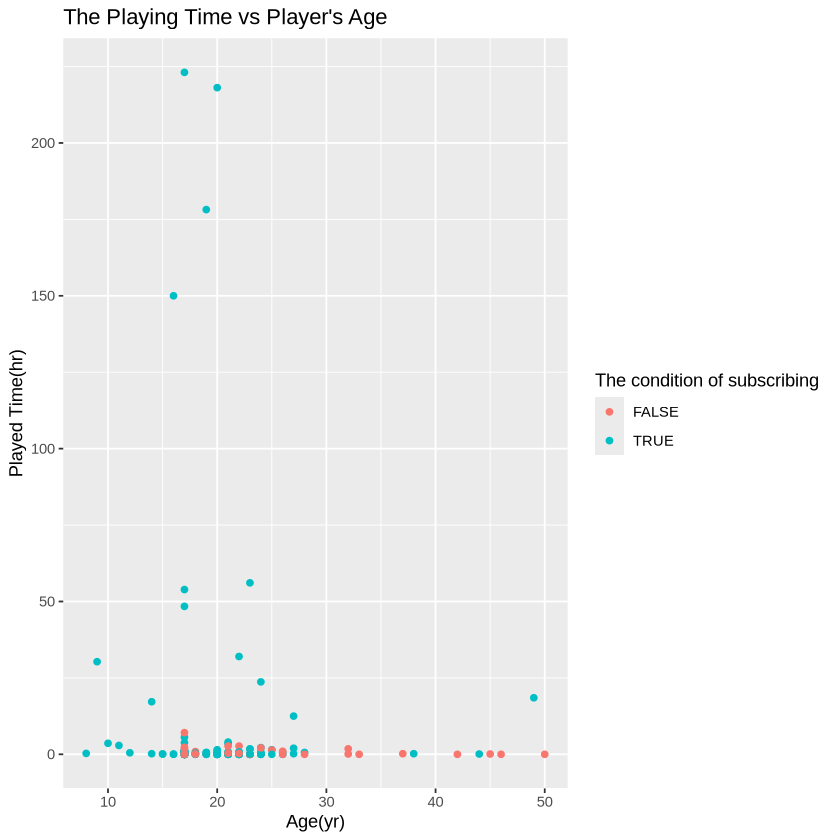

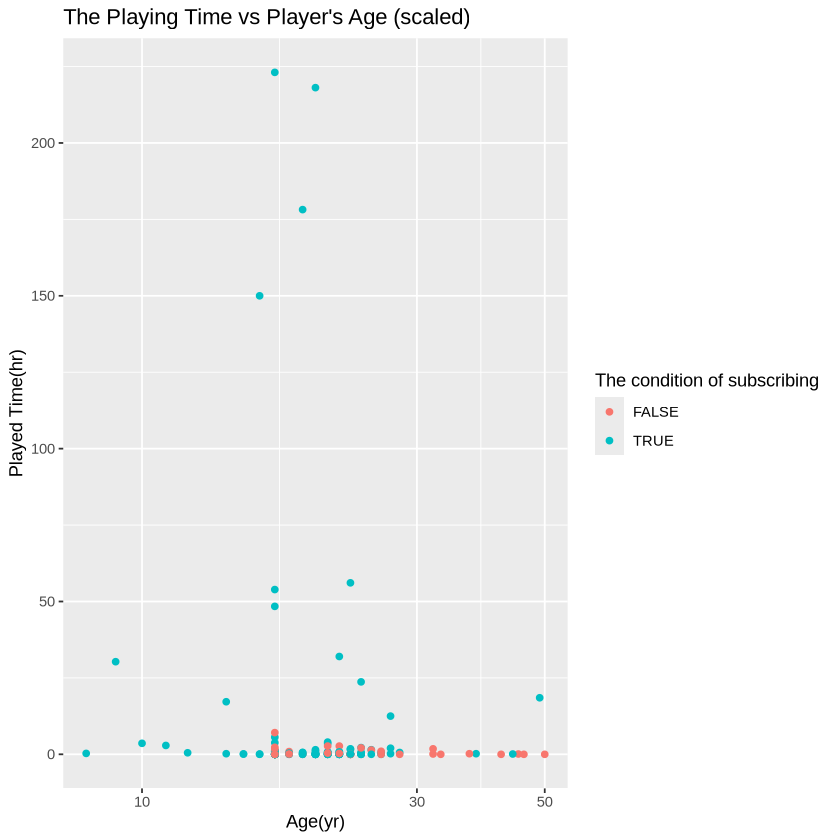

In [7]:
players_plot<- ggplot(players_new_frame, aes(x=Age, y=played_hours)) +
               geom_point(aes(color=subscribe))+
               labs(x="Age(yr)",y="Played Time(hr)",color="The condition of subscribing", title="The Playing Time vs Player's Age")

players_plot

players_scaled<-ggplot(players_new_frame, aes(x=Age, y=played_hours)) +
               geom_point(aes(color=subscribe))+
               labs(x="Age(yr)",y="Played Time(hr)",color="The condition of subscribing", title="The Playing Time vs Player's Age (scaled)")+
               scale_x_log10()
players_scaled

- To verify the hypothesis proposed earlier, I created scatter plots showing the relationship between play time, age, and subscription. I used the `scale_x_log10()`  to make the figures more readable.
- As can be seen from the figure, as the game duration increases, blue dots (subscribed players) appear much more frequently than red dots (non-subscribed players). As age increases, red dots appear much more frequently than blue dots.

In [11]:
set.seed(1234)

players_split<-initial_split(players_new_frame, prop = 0.7, strata= subscribe)
players_training<- training(players_split)
players_testing<-testing(players_split)

In [12]:
players_recipe<-recipe(subscribe~played_hours + Age, data = players_training)|>
step_scale(all_predictors())|> 
step_center(all_predictors())
players_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [13]:
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors= tune())|>
          set_engine("kknn")|>
          set_mode("classification")

In [18]:
players_vfold<-vfold_cv(players_training, v=5, strata= subscribe)

In [21]:
set.seed(1234)
k_val<-tibble(neighbors= seq(from =1, to= 30, by =1))
knn_rsults<-workflow()|>
         add_recipe(players_recipe)|>
         add_model(knn_spec)|>
         tune_grid(resamples =players_vfold, grid=k_val)|>
         collect_metrics()
accuracies<-filter(knn_rsults, .metric =="accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4309524,5,0.045826032,Preprocessor1_Model01
2,accuracy,binary,0.4383598,5,0.051150641,Preprocessor1_Model02
3,accuracy,binary,0.5421042,5,0.047553674,Preprocessor1_Model03
4,accuracy,binary,0.5270248,5,0.042326790,Preprocessor1_Model04
5,accuracy,binary,0.5775539,5,0.041828060,Preprocessor1_Model05
6,accuracy,binary,0.5849613,5,0.036214061,Preprocessor1_Model06
7,accuracy,binary,0.6151201,5,0.036746660,Preprocessor1_Model07
8,accuracy,binary,0.6003053,5,0.044844335,Preprocessor1_Model08
9,accuracy,binary,0.7249491,5,0.022020622,Preprocessor1_Model09


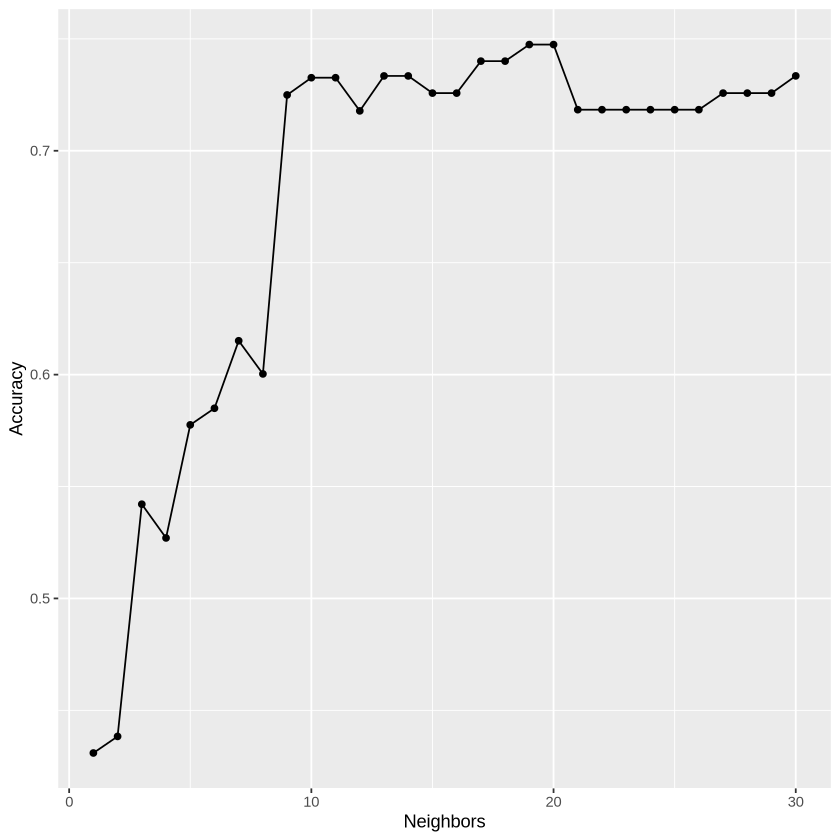

In [23]:
accuracy_plot<-ggplot(accuracies, aes( x=neighbors, y= mean))+
               geom_point()+
               geom_line()+
               labs(x= "Neighbors", y= "Accuracy")
accuracy_plot

In [24]:
best_k <- accuracies |>
          arrange(desc(mean))|>
          head(1)|>
          pull(neighbors)
best_k

[1] 19

In [25]:
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors= best_k)|>
          set_engine("kknn")|>
          set_mode("classification")
knn_fit<- workflow()|>
         add_recipe(players_recipe)|>
         add_model(knn_spec)|>
         fit(data= players_testing)
my_prediction<-predict(knn_fit,players_testing)|>
          bind_cols(players_testing)
my_prediction

.pred_class,played_hours,Age,subscribe
<fct>,<dbl>,<dbl>,<fct>
TRUE,30.3,9,TRUE
TRUE,0.0,17,FALSE
TRUE,0.1,21,TRUE
TRUE,0.0,17,TRUE
TRUE,0.1,17,TRUE
TRUE,0.2,22,TRUE
TRUE,0.0,17,TRUE
TRUE,0.3,8,TRUE
TRUE,0.0,33,FALSE


In [26]:
accuracy<-my_prediction|>
          accuracy(truth= subscribe, estimate= .pred_class, event_level= "first")
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136
